In [33]:
! pip install -r requirements.txt --quiet

# Supervisor Agent with Specialized Agents, Azure AI Search, and Evaluation SDK

This notebook introduces a **supervisor agent** that orchestrates multiple specialized agents to solve complex tasks. It leverages vectorized data from **Azure AI Search** for grounding, ensuring context-aware responses. The workflow is evaluated using the **Azure AI Evaluation SDK**, which measures the coherence and groundedness of the agent outputs. Additionally, **agent traces** are captured and visualized by logging graph invocations with **Azure AI Inference Tracer**.

- Orchestrate multiple specialized agents using a **supervisor agent** to handle complex tasks.
- Utilize **Azure AI Search** for vectorized data to ensure context-aware responses.
- Evaluate agent performance using the **Azure AI Evaluation SDK** to assess coherence and groundedness.
- Capture and visualize **agent traces** with **Azure AI Inference Tracer** for deeper insights into agent behavior.

🔗 [LangGraph Multi-agent Supervisor](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

In [1]:
from dotenv import load_dotenv
from os import environ
from langchain_openai import AzureChatOpenAI
from typing_extensions import TypedDict,Literal
from langgraph.types import Command
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from  user_tools import get_weather_tool
from user_functions import vector_search  
from utils import pretty_print_messages,extract_graph_response
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.prebuilt import create_react_agent

from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from langchain_azure_ai.callbacks.tracers import AzureAIInferenceTracer

load_dotenv(override=True)



members = ["document_search", "weather"]

options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = AzureChatOpenAI(
        temperature=0,
        azure_deployment=environ["AZURE_OPENAI_MODEL"],
        api_version=environ["AZURE_OPENAI_API_VERSION"]
    )


llm_with_tools = create_react_agent(llm, tools=[get_weather_tool])



## Configure tracing for Azure AI Foundry

You can use the tracing capabilities in Azure AI Foundry by creating a tracer. Logs are stored in Azure Application Insights and can be queried at any time using Azure Monitor or Azure AI Foundry portal. Each AI Hub has an Azure Application Insights associated with it

🔗 [Azure AI Foundry Tracing LangChain](https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/develop/langchain#tracing)

In [2]:
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=environ["AZURE_AI_PROJECT_CONNECTION_STRING"],
)

application_insights_connection_string = project_client.telemetry.get_connection_string()

tracer = AzureAIInferenceTracer(
    connection_string=application_insights_connection_string,
    enable_content_recording=True,
)

In [3]:
def document_search(state: MessagesState) -> Command[Literal["supervisor"]]:
    messages = state["messages"]
    last_user_message = next((msg for msg in reversed(messages)), None)
    if not last_user_message:
        return Command(goto="supervisor")

    query = last_user_message.content
    context = vector_search(query)  

    
    messages.append(
    SystemMessage(
        content=(
            f"You are a helpful assistant. Use only the information in the context below to answer the user's question. "
            f"If the context does not contain the answer, respond with \"I don't know.\"\n\nContext:\n{context}"
        )
    )
)

    response = llm.invoke(messages)

    return Command(
        update={
            "messages": [
                HumanMessage(content=response.content, name="document_search")
            ]
        },
        goto="supervisor",
    )


def weather(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = llm_with_tools.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="weather")
            ]
        },
        goto="supervisor",
    )

def supervisor(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})



In [4]:

builder = StateGraph(MessagesState)
builder.add_node("document_search", document_search)
builder.add_node("weather", weather)
builder.add_node("supervisor", supervisor)

builder.set_entry_point("supervisor")

graph = builder.compile()


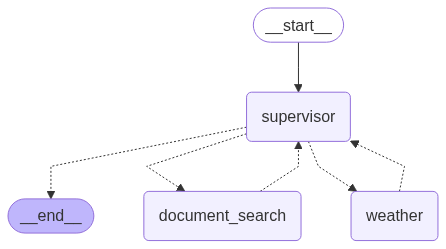

In [5]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Unable to display the graph visualization. This won't affect the rest of the notebook.")
    print(f"Reason: {e}")

In [6]:
for step in graph.stream({"messages": [{"role": "user", "content": "Describe the resource intensity of data center facility infrastructure"}]},config={"callbacks": [tracer]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node document_search:


================================ Human Message =================================
Name: document_search

The resource intensity of data center facility infrastructure is described using two key metrics: **Power Usage Effectiveness (PUE)** and **Water Usage Effectiveness (WUE)**. 

- **PUE** is the ratio of the total electricity demand of the data center to the electricity demand of the IT equipment. It is dimensionless (kWh/kWh) and reflects the efficiency of the facility's energy use.
- **WUE** is the total water consumption of the data center divided by the electricity demand of the IT equipment, reported in liters per kWh. It primarily accounts for on-site water consumption associated with cooling infrastructure.

These metrics are influenced by factors such as cooling systems, operational practices, and climatic conditions. Additionally, U.S. data centers in 2023 had an indirect water footprint of nearly 800 billio

In [7]:
for step in graph.stream({"messages": [{"role": "user", "content": "what is the weather in sf"}]},config={"callbacks": [tracer]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node weather:


================================ Human Message =================================
Name: weather

The weather in San Francisco is currently 60°F and foggy.


Update from node supervisor:






## Introduction to Evaluation with the Azure AI SDK

Evaluation is a critical part of building reliable and trustworthy generative AI applications. It ensures that AI outputs are grounded, coherent, and aligned with the intended context, helping to prevent issues like fabrication, irrelevance, and harmful content.

The **Azure AI Evaluation SDK** allows you to systematically evaluate the performance of your AI workflows directly in your development environment. This helps build confidence in your application's behavior before deploying it to users.

In this example, we will use the **GroundednessEvaluator** and **CoherenceEvaluator** from the Azure AI Evaluation SDK to assess the outputs of our existing **LangGraph**-based agent. These evaluators will help us measure how well the agent’s responses stay true to the source context and maintain logical flow throughout the conversation.


🔗 [Evaluate your Generative AI application locally with the Azure AI Evaluation SDK](https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/develop/evaluate-sdk)

In [8]:
from azure.ai.evaluation import GroundednessEvaluator,CoherenceEvaluator,RelevanceEvaluator
from azure.ai.projects.models import Evaluation, Dataset, EvaluatorConfiguration, ConnectionType,EvaluationTarget
import json
import random
import string


model_config = {
    "azure_endpoint": environ["AZURE_OPENAI_ENDPOINT"],
    "api_key": environ["AZURE_OPENAI_API_KEY"],
    "azure_deployment": environ["AZURE_OPENAI_MODEL"],
    "api_version": environ["AZURE_OPENAI_API_VERSION"],
}


# Initialize Evaluators
groundedness_eval = GroundednessEvaluator(model_config=model_config)
coherence_eval = CoherenceEvaluator(model_config=model_config)


In [9]:

inputs = [
    {
        "query": "Describe the resource intensity of data center facility infrastructure",
        "context": "Data centers consume large amounts of electricity for power and cooling systems.",
        "expected_output": "Description of resource intensity with two key metrics: Power Usage Effectiveness (PUE) and Water Usage Effectiveness (WUE)"
    },
    {
        "query": "What is the weather in SF?",
        "context": "The user is asking for weather details for San Francisco.",
        "expected_output": "Includes weather for San Francisco with temperature."
    }
]


def evaluate(query, response, context, expected_output):

    groundedness_score = groundedness_eval(
        query=query,
        context=context,
        response=response
    )

    coherence_score = coherence_eval(query=query,
        context=context,
        response=response
        )

    print(f"Evaluating: {query}")
    print(f"Groundedness Score: {groundedness_score}")
    print(f"Coherence Score: {coherence_score}")
    print("---------------------------------------------------")

    return {"query":query, "context":context, "response":response}


data = []

for query_input in inputs:
    query = query_input["query"]
    context = query_input["context"]
    expected_output = query_input["expected_output"]


    final_response = extract_graph_response(query,graph)

    # Evaluate the final response
    data.append(evaluate(query, final_response, context, expected_output))


Evaluating: Describe the resource intensity of data center facility infrastructure
Groundedness Score: {'groundedness': 5.0, 'gpt_groundedness': 5.0, 'groundedness_reason': 'The RESPONSE thoroughly and accurately addresses the QUERY, providing all relevant details about resource intensity metrics and their contributing factors, as supported by the CONTEXT.', 'groundedness_result': 'pass', 'groundedness_threshold': 3}
Coherence Score: {'coherence': 4.0, 'gpt_coherence': 4.0, 'coherence_reason': 'The RESPONSE is coherent, logically organized, and effectively addresses the QUERY with clear explanations and relevant examples. It demonstrates a smooth flow of ideas and uses appropriate transitions.', 'coherence_result': 'pass', 'coherence_threshold': 3}
---------------------------------------------------
Evaluating: What is the weather in SF?
Groundedness Score: {'groundedness': 5.0, 'gpt_groundedness': 5.0, 'groundedness_reason': "The RESPONSE provides a fully correct and complete answer t

In [10]:
with open("evaluate_test_data.jsonl", "w") as f:
    for entry in data:
        f.write(json.dumps(entry) + "\n")

data_id, _ = project_client.upload_file("./evaluate_test_data.jsonl")

Uploading evaluate_test_data.jsonl (< 1 MB): 100%|##########| 1.53k/1.53k [00:00<00:00, 12.9kB/s]


